<a href="https://colab.research.google.com/github/ea-Mitsuoka/ionicons/blob/master/bqml_kmeans_iris_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
```
Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
```
---

# 概要
このノートブックでは、K-Meansクラスタリングを使用して外れ値を探すタスクを実行します。これは、データセット内のグループを見つけるためのシンプルな教師なし学習手法です。

### データセット
デフォルトでは、このノートブックはBigQueryのサンプルであるbigquery-public-dataプロジェクトのirisデータセットを使います。これは 3 種のアイリス（Iris setosa、Iris virginicaおよびIris versicolor）それぞれ50サンプルで構成されています。各サンプルについて、がくと花びらの長さと幅（センチメートル）が測定されています。これら4つの機能の組み合わせに基づいて、統計学者で生物学者のロナルドフィッシャーは、種を互いに区別するための線形判別モデルを開発しました。

### 目的
がくと花びらの長さと幅をクラスタリングし、各種別の外れ値を特定します。

### 費用

このチュートリアルでは、Google BigQuery および BigQuery ML を使います。金額について詳細は  [BigQuery ML pricing](https://cloud.google.com/bigquery-ml/pricing) [Pricing
Calculator](https://cloud.google.com/products/calculator/)
を参照ください。

### 事前準備

**このノートブックを実行するには事前に次の手順が必要です。**

1. [GCP プロジェクトの作成もしくは選択](https://console.cloud.google.com/cloud-resource-manager). 最初にアカウントを作成すると、300ドルの無料クレジットが付与されます。

2. [課金設定を有効にします](https://cloud.google.com/billing/docs/how-to/modify-project)

3.   [BigQuery API](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) を有効にします。

4. 下のセルを実行し、Google アカウントでログインして表示されるキーをセルに入力します。

5. 「プロジェクト変数の設定」のセルにご自身のプロジェクトIDを入力してください。

In [ ]:
import pandas as pd
import numpy as np
import sys
from google.cloud import bigquery
from google.colab import auth
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
auth.authenticate_user()

In [ ]:
#@title プロジェクト変数の設定 { run: "auto", display-mode: "form" }
project_id = 'kmikibqml' #@param {type:"string"}
#dataset_name = "ga" #@param {type:"string"}
client = bigquery.Client(project=project_id)

まず、モデルを保存するためのデータセットが必要になります。 （エラーが発生した場合は、BigQueryコンソールから"iris"というデータセットを作成してください）。

In [ ]:
%%bash -s "$project_id"

gcloud config set project $1
bq --location=US mk -d iris

Process is terminated.


## kmeansでクラスタリング
このセクションでは、k-meansクラスタリングアルゴリズムを使用してirisデータをセグメント化します。 sepal_length, sepal_width, petal_length, petal_width の4つの指標に基づいてグループ分けします。
最初にデータセットをクエリしk-meansアルゴリズムを適用します。

In [ ]:
query = '''
SELECT * from bigquery-public-data.ml_datasets.iris
'''
iris = client.query(query).to_dataframe()

In [ ]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,2.5,3.0,1.1,versicolor
1,5.0,2.0,3.5,1.0,versicolor
2,5.7,2.6,3.5,1.0,versicolor
3,6.0,2.2,4.0,1.0,versicolor
4,5.8,2.6,4.0,1.2,versicolor


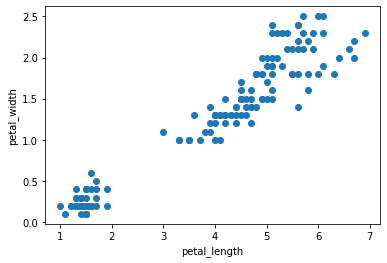

In [ ]:
plt.scatter(iris.petal_length, iris.petal_width)
plt.xlabel("petal_length"); plt.ylabel("petal_width")
plt.show()

In [ ]:
#df = df[df['petal_length'] < 150]
num_points = len(iris)

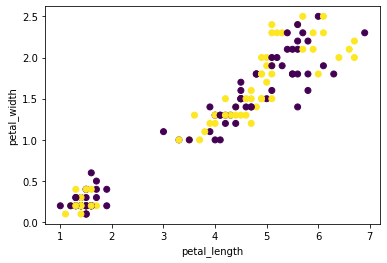

In [ ]:
y = np.random.binomial(n = 1, p = 0.5, size = num_points)    # 割り振り
plt.scatter(iris.petal_length, iris.petal_width, c = y)
plt.xlabel("petal_length"); plt.ylabel("petal_width")
plt.show()

In [ ]:
#各クラスターの重心を計算
center = pd.DataFrame(iris, columns = ["petal_length", "petal_width"]).assign(y = y).groupby(y).mean()
center

,petal_length,petal_width,y
0,3.604878,1.121951,0
1,3.944118,1.291176,1


ここでは、k-means法のイメージを紹介するため、データ全体を2クラスタに分割して可視化しています。具体的には、各データポイントの重心からの近さを2乗距離で計算し、この結果をもとに各データポイントのクラスターを近いほうの重心に対応するクラスターに更新します。

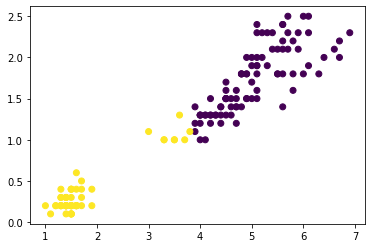

In [ ]:
# クラスターの重心をnumpy配列で抽出する。
center_cluster_0 = center.loc[0, ["petal_length", "petal_width"]].values
center_cluster_1 = center.loc[1, ["petal_length", "petal_width"]].values

# 各データポイントについてクラスターからの2乗距離を計算する。_
dist_cluster_0 = (iris.petal_length.values.reshape(num_points) - center_cluster_0[0])**2 + (iris.petal_width.values.reshape(num_points) - center_cluster_0[1])**2
dist_cluster_1 = (iris.petal_length.values.reshape(num_points) - center_cluster_1[0])**2 + (iris.petal_width.values.reshape(num_points) - center_cluster_1[1])**2
new_cluster_id = dist_cluster_0 < dist_cluster_1

# 可視化
plt.scatter(iris.petal_length, iris.petal_width, c = new_cluster_id)
plt.show()

2つのクラスターに分かれました。このように重心の計算・クラスターの更新を繰り返すことでクラスターをまとめていきます。

トレーニング データを確認できたので、 BQML で K 平均法モデルを作成します。

CREATE MODEL ステートメントを model_type=kmeans オプションで使用することで、K 平均法モデルの作成とトレーニングが行えます。

In [ ]:
query = '''
CREATE OR REPLACE MODEL
  iris.iris_clusters
OPTIONS
  (model_type='kmeans',
    num_clusters=4,
    standardize_features = TRUE) AS
SELECT
  DISTINCT petal_length,
  petal_width,
  petal_length,
  petal_width,
  species
FROM
  `bigquery-public-data.ml_datasets.iris`
'''
client.query(query)

k-meansでは、データポイントがクラスターの中心（「質量の中心」）に近いほど、クラスター内の他のデータポイントと比較される「平均」が高くなり、この中心はセントロイドと呼ばれます。つまり、データの異常を見つけるために実行できるアプローチの1つは、クラスターの重心から最も離れたデータポイントを見つけることです。 ML.PREDICT関数は、各データポイントと最も近い重心からの距離を含む配列を返します。UNNEST関数を使用して、この配列を平坦化し、最小距離（最も近い重心までの距離）のみを取ることができます。

In [ ]:
query = """
WITH
  Distances AS (
  SELECT
    DISTINCT ML.CENTROID_ID,
    sepal_length,
    sepal_width,
    petal_length,
    petal_width,
    species,
    MIN(NEAREST_CENTROIDS_DISTANCE.DISTANCE) AS distance_from_closest_centroid
  FROM
    ML.PREDICT(MODEL iris.iris_clusters,
      (
      SELECT
        DISTINCT sepal_length,
        sepal_width,
        petal_length,
        petal_width,
        species
      FROM
        `bigquery-public-data.ml_datasets.iris` )) AS ML
  CROSS JOIN
    UNNEST(NEAREST_CENTROIDS_DISTANCE) AS NEAREST_CENTROIDS_DISTANCE
  GROUP BY
    ML.CENTROID_ID,
    sepal_length,
    sepal_width,
    petal_length,
    petal_width,
    species ),
  Threshold AS (
    # BigQueryの近似集計関数を使用して95パーセンタイルを計算
  SELECT
    ROUND(APPROX_QUANTILES(distance_from_closest_centroid,10000)[
    OFFSET
      (9500)],2) AS threshold
  FROM
    Distances)
SELECT
  d.*
FROM
  Distances d
JOIN
  Threshold
ON
  d.distance_from_closest_centroid > Threshold.threshold
  """
df = client.query(query).to_dataframe()
df

,CENTROID_ID,sepal_length,sepal_width,petal_length,petal_width,species,distance_from_closest_centroid
0,3,7.9,3.8,6.4,2.0,virginica,2.391954
1,3,7.7,2.6,6.9,2.3,virginica,1.773253
2,2,7.0,3.2,4.7,1.4,versicolor,1.710653
3,2,4.9,2.5,4.5,1.7,virginica,1.962832
4,3,7.7,3.8,6.7,2.2,virginica,2.300738
5,1,4.5,2.3,1.3,0.3,setosa,2.233512
6,2,6.0,2.2,5.0,1.5,virginica,1.907077
7,2,5.0,2.0,3.5,1.0,versicolor,2.113245


これらの外れ値が実際にどれほどまれであるかを確認してみましょう。virginicaの種の場合、がく片の長さ7.7、がく片の幅は2.6、花弁の長さは6.9、花弁の幅は2.3というのはどれほど珍しいでしょうか。 

virginica種の特徴のヒストグラムをプロットしてみましょう。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed2eeb4ba8>,
      dtype=object)

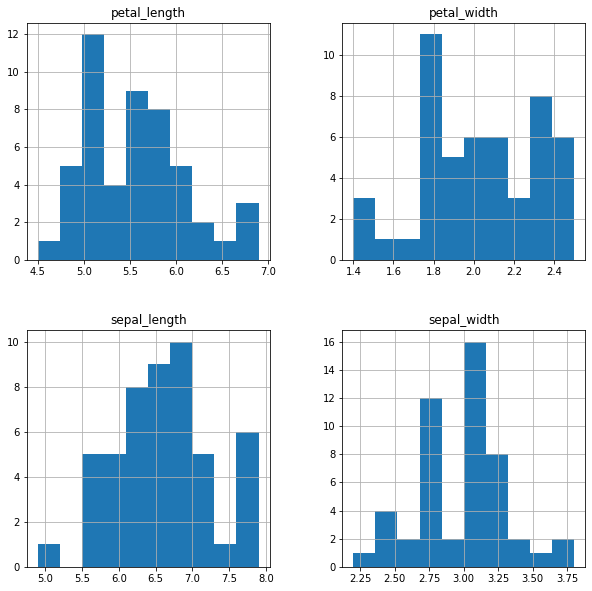

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
iris.query('species=="virginica"').hist(bins=10)


In [ ]:
_ = df.hist(column='weight_pounds',by='is_male', layout=(1,2),  sharey=True, sharex=True)

### クリーンアップ
すべての作業が完了したら、以下のURLを参考に、プロジェクトを必要に応じてクリーンアップしてください。
https://cloud.google.com/go/getting-started/delete-tutorial-resources?hl=ja